# Weighed Scaled Pinball Loss (WSPL)

The WSPL, for a single level, is calculated as:  

$$
WSPL = \sum_{series} w_i \cdot SPL = \sum_{series} w_i \cdot \frac{1}{h}\frac{\sum_{days} PL}{S_i}\\
= \sum_{series} w_i \cdot \frac{1}{h}\frac{\sum_{days} \frac{1}{9}\sum_u PL(u)}{1/(n-1) \cdot \sum_t |Y_t - Y_{t-1}|}
$$

Where $w_i$ and $S_i$ are constants per series, computed as described in the M5 Competitors guide.  


The Pinball Loss for a single quantile is calculated as:

$$
PL(u) = \frac{1}{h}\sum_{days}\left[ E \cdot u \text{  or  } E\cdot (1-u)  \right]
$$

Where $E$ is the absolute prediction error: $|Y_t - Q_t(u)|$ and the left or right part is evaluated based on wheter the quantity is over- or underpredicted. 

Normalising a particular series with $c_i$ gives:  

$$
E = |Y_t - Q_t(u)| = c_i \cdot |Y_t/c_i - Q_t(u)/c_i| = c_i \cdot E'
$$

Where $E'$ is the prediction error as calculated with the normalised quantities. 

From this follows that:
$$
PL(u) = \frac{1}{h}\sum_{days}\left[ c_i \cdot E' \cdot u \text{  or  } c_i \cdot E'\cdot (1-u)  \right]\\
= \frac{c_i}{h}\sum_{days}\left[ E' \cdot u \text{  or  }  E'\cdot (1-u)  \right]\\
= c_i \cdot PL(u)'
$$

And subsequently:  

$$
WSPL = \sum_{series} w_i \cdot \frac{1}{h}\frac{\sum_{days} \frac{1}{9}\sum_u c_i \cdot PL(u)'}{S_i}\\
= \sum_{series} w_i \cdot \frac{1}{h}\frac{\sum_{days} c_i PL'}{S_i}\\
$$

Setting $c_i = S_i / w_i$ for each series (and thus $Y_t' = Y_t / c_i = w_i \cdot Y_t / S_i$) gives:  

$$
WSPL = \sum_{series} w_i \cdot \frac{1}{h}\frac{S_i / w_i\sum_{days} PL'}{S_i}\\
 = \sum_{series} \frac{1}{h}\sum_{days} PL'\\
$$

So with the chosen normalisation constant, minimizing the 'naive' pinball loss corresponds to the minimization of the weighed scaled pinball loss. 

**Note**: For the values to coincode exactly, the constants $h$ and $\frac{1}{9}$ need to be implemented correctly. This, however, only scales the total loss and does not influence any training decisions. (But could influence magnitude of gradient for all training steps with the same constant)

## Effect of normalisation for higher aggregation levels

Within the M5Forecast - Uncertainty each (aggregated) series must be provided directly, resulting in a total of $42,840$ series (compared to the ~$30k$ product-level series for the M5Forecast - Accuracy challenge).  

For each aggregation level the same computations hold as for the product level pinball loss, but with their respective $w_i$ and $S_i$. 

## Approximate conversion of sales
The weight of each series is calculated using the 28 days preceding the prediction range. To convert the complete dataset in a consistent manner, the weights as calculated using the final 28 days is used. These are available through the `Referee` object. 

### Load data

In [1]:
cd ..

C:\Users\guest0\joeran\M5Forecast


In [2]:
# basic imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# own imports
from flow import load_data, select_dates, sales_to_money, select_final_day, select_day_nums
from evaluation import Referee, CrossValiDataGenerator

In [3]:
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions/'

# General settings for figures
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 13})  # 12, 16
plt.rcParams["savefig.bbox"] = 'tight'

In [4]:
# Load data
calendar, sales_train_validation, sell_prices = load_data()

# Set up generator
cv_generator = CrossValiDataGenerator(sales_train_validation)
sales_train, sales_true = cv_generator.get_train_val_split(fold=1, train_size=-1)

# create referee for fold 1
ref = Referee(sales_true, sales_train, sell_prices, calendar)

Initializing Referee
Converting true sales to quantile form
Calculating weights for each level...
Calculating scale for each level...
Finished setup.


In [5]:
sales_train_validation.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


### Calulate aggregate demand
`sales_train_validation` contains sales on product level, for each of the ~$30k$ products. Below the aggregated demands are calculated. 

In [6]:
sales_agg = {}

for level, groupby in ref.aggregation_levels.items():
    if level == 12:
        d_list = select_day_nums(sales_train_validation, as_int=False)
        sales_agg[level] = sales_train_validation[d_list]
    else:
        sales_agg[level] = sales_train_validation.groupby(groupby).sum()

### Example: aggregates by state and category (level 6)
For each series, the normalisation constant is:

$$
c_i = \frac{S_i}{w_i}
$$

In [7]:
sales_agg[6]

d_1   d_2   d_3   d_4   d_5   d_6   d_7    d_8    d_9  \
state_id cat_id                                                               
CA       FOODS      10101  9862  6944  7864  7178  8256  9005  11870  10977   
         HOBBIES     1802  1561  1472  1405  1181  1459  1314   1986   1482   
         HOUSEHOLD   2292  2382  1692  1778  1566  1607  1932   2754   2237   
TX       FOODS       6853  7030  5124  5470  4602  7067  4671   7055   6920   
         HOBBIES      879   870   526   809   501   831   390    785    794   
         HOUSEHOLD   1706  1730  1128  1102   809  1108  1165   1600   1662   
WI       FOODS       6224  5866  5106  5544  2823  6770  6814   8826   6965   
         HOBBIES     1083   926   684   455   132   930  1240   1215    623   
         HOUSEHOLD   1691  1522  1107   985   354  1183  1479   1841   1076   

                    d_10  ...  d_1904  d_1905  d_1906  d_1907  d_1908  d_1909  \
state_id cat_id           ...                                                   
CA       FOODS      8637  ...   10732   13094   14855   11217   10088    9863   
         HOBBIES    1508  ...    1658    2176    2330    1706    1849    1646   
         HOUSEHOLD  1677  ...    3865    5294    5847    4129    3847    3639   
TX       FOODS      5505  ...    6994    7944    8717    6834    7066    6242   
         HOBBIES     524  ...    1107    1124    1461     830    1025     980   
         HOUSEHOLD  1290  ...    2699    3392    3531    2204    2831    2378   
WI       FOODS      4759  ...   10956   10969   10925    8100    7794    7527   
         HOBBIES     583  ...    1021    1334    1029     787     913     846   
         HOUSEHOLD  1089  ...    2757    3035    2945    2252    2157    2222   

                    d_1910  d_1911  d_1912  d_1913  
state_id cat_id                                     
CA       FOODS        9479   10991   13845   14806  
         HOBBIES      1590    2015    2367    2357  
         HOUSEHOLD    3419    4089    5622    6024  
TX       FOODS        6167    6839    7849    7765  
         HOBBIES       882    1056    1222    1266  
         HOUSEHOLD    2553    2720    3195    3251  
WI       FOODS        7671    8874   10233   10083  
         HOBBIES       881    1014    1198    1060  
         HOUSEHOLD    2391    2919    3431    3183  

[9 rows x 1913 columns]

In [8]:
weights = ref.weights[6]
scales = ref.scales_WSPL[6]

In [9]:
weights

state_id  cat_id   
CA        FOODS        0.237349
          HOBBIES      0.059405
          HOUSEHOLD    0.136996
TX        FOODS        0.147692
          HOBBIES      0.041424
          HOUSEHOLD    0.090253
WI        FOODS        0.184660
          HOBBIES      0.027841
          HOUSEHOLD    0.074380
dtype: float64

In [10]:
scales

state_id  cat_id   
CA        FOODS        1310.929899
          HOBBIES       226.405736
          HOUSEHOLD     519.899097
TX        FOODS         975.826872
          HOBBIES       133.530536
          HOUSEHOLD     331.594264
WI        FOODS        1066.855550
          HOBBIES       158.725969
          HOUSEHOLD     332.409984
dtype: float64

In [11]:
norm = scales / weights
norm

state_id  cat_id   
CA        FOODS        5523.212061
          HOBBIES      3811.230479
          HOUSEHOLD    3794.984299
TX        FOODS        6607.153813
          HOBBIES      3223.530156
          HOUSEHOLD    3674.064648
WI        FOODS        5777.414058
          HOBBIES      5701.242316
          HOUSEHOLD    4469.054733
dtype: float64

In [12]:
(sales_agg[6].T / norm).max().max()

2.9915563295105425

In [13]:
global_norm = (sales_agg[6].T / norm).max().max()

norm = norm * global_norm
norm

state_id  cat_id   
CA        FOODS        16523.000000
          HOBBIES      11401.510662
          HOUSEHOLD    11352.909301
TX        FOODS        19765.672810
          HOBBIES       9643.372041
          HOUSEHOLD    10991.171352
WI        FOODS        17283.459594
          HOBBIES      17055.587536
          HOUSEHOLD    13369.428973
dtype: float64

In [14]:
sales_conv = sales_agg[6].T / norm
sales_conv.head()

state_id        CA                            TX                      \
cat_id       FOODS   HOBBIES HOUSEHOLD     FOODS   HOBBIES HOUSEHOLD   
d_1       0.611330  0.158049  0.201887  0.346712  0.091151  0.155215   
d_2       0.596865  0.136912  0.209814  0.355667  0.090217  0.157399   
d_3       0.420263  0.129106  0.149037  0.259237  0.054545  0.102628   
d_4       0.475943  0.123229  0.156612  0.276742  0.083892  0.100262   
d_5       0.434425  0.103583  0.137938  0.232828  0.051953  0.073605   

state_id        WI                      
cat_id       FOODS   HOBBIES HOUSEHOLD  
d_1       0.360113  0.063498  0.126483  
d_2       0.339400  0.054293  0.113842  
d_3       0.295427  0.040104  0.082801  
d_4       0.320769  0.026677  0.073676  
d_5       0.163335  0.007739  0.026478

Note: transposing the sales results in the correct element-wise division. 

In [15]:
sales_conv.min().min(), sales_conv.max().max()

(0.0, 1.0)

### Distribution of weights

In [16]:
norm = ref.scales_WSPL[12] / ref.weights[12]

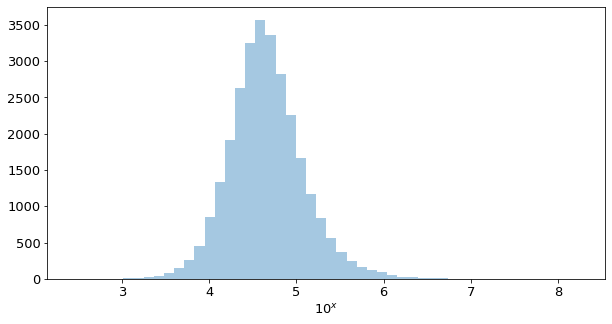

In [17]:
df = norm[norm != np.inf]
df = df.apply(np.log10)
sns.distplot(df, kde=False)
plt.xlabel("$10^x$")
plt.show()

In [18]:
norm[norm != np.inf].quantile([0.5, 0.95, 0.99])

0.50     42998.856019
0.95    247817.739269
0.99    748024.979968
dtype: float64

In [19]:
norm[norm == np.inf]

id
HOBBIES_1_018_CA_1_validation    inf
HOBBIES_1_070_CA_1_validation    inf
HOBBIES_1_087_CA_1_validation    inf
HOBBIES_1_095_CA_1_validation    inf
HOBBIES_1_112_CA_1_validation    inf
                                ... 
FOODS_3_745_WI_3_validation      inf
FOODS_3_767_WI_3_validation      inf
FOODS_3_785_WI_3_validation      inf
FOODS_3_790_WI_3_validation      inf
FOODS_3_824_WI_3_validation      inf
Length: 2149, dtype: float64

### Convert all levels

In [20]:
sales_conv = {}
norm_conv = {}

for level, groupby in ref.aggregation_levels.items():
    # select relevant quantities
    sales = sales_agg[level]
    weights = ref.weights[level]
    scales = ref.scales_WSPL[level]
    
    # calculate series-wise normalization constant
    norm = scales / weights
    
    print("Level {} has {} series with zero weight (and subsequent norm inf)".format(
        level, weights[weights == 0].index.size))
    
    clip_norm = norm[norm != np.inf].quantile(0.99)
    print("Clipping {} series to 99th quantile normalisation of {}".format(
        (norm > clip_norm).sum(), clip_norm))
    norm.clip(upper=clip_norm, inplace=True)
    
    # calculate level-wise constant to normalise each level to [0, 1]
    global_norm = (sales.T / norm).max().max()
    norm *= global_norm
    
    # calculate converted series
    sales_conv[level] = sales.T / norm
    
    # save normalisation
    norm_conv[level] = norm

Level 1 has 0 series with zero weight (and subsequent norm inf)
Clipping 0 series to 99th quantile normalisation of 4254.896972915561
Level 2 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 4982.64554909154
Level 3 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 6365.5405296112785
Level 4 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 5141.538771771288
Level 5 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 7591.995869495459
Level 6 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 6540.774632878925
Level 7 has 0 series with zero weight (and subsequent norm inf)
Clipping 1 series to 99th quantile normalisation of 12342.115947374708
Level 8 has 0 series with zero weight (and subsequent norm in

### Set id similar to submission

In [21]:
def get_idx(idx, level, postfix=""):
    if level == 1:
        # total aggregates
        return "Total_X" + postfix
    elif (level >= 2 and level <= 5) or level == 10:
        # single-key aggregates
        return idx + "_X" + postfix
    elif level >= 6 and level <= 9:
        # two-key aggregates
        return idx[0] + "_" + idx[1] + postfix
    elif level == 11:
        # two-key aggregates reversed order
        return idx[1] + "_" + idx[0] + postfix
    elif level == 12:
        return idx.replace('_validation', '') + postfix
    assert False, "Index Error, level not recognised"

In [22]:
for level, groupby in ref.aggregation_levels.items():
    # convert indices
    idx = sales_conv[level].columns.map(lambda x: get_idx(x, level=level))
    # set new indices
    sales_conv[level].columns = idx
    norm_conv[level].index = idx

### Save results

In [23]:
for level, df in sales_conv.items():
    df.to_csv(os.environ['DATA_DIR'] + "/prep/converted_sales_level_{}.csv".format(level))
    norm_conv[level].to_csv(os.environ['DATA_DIR'] + "/prep/norm_level_{}.csv".format(level),
                            index_label='id', header=['norm'])

In [24]:
sales = pd.concat(sales_conv.values(), axis=1)
norm = pd.concat(norm_conv.values(), axis=0)
sales.head()

,Total_X,CA_X,TX_X,WI_X,CA_1_X,CA_2_X,CA_3_X,CA_4_X,TX_1_X,TX_2_X,...,FOODS_3_818_WI_3,FOODS_3_819_WI_3,FOODS_3_820_WI_3,FOODS_3_821_WI_3,FOODS_3_822_WI_3,FOODS_3_823_WI_3,FOODS_3_824_WI_3,FOODS_3_825_WI_3,FOODS_3_826_WI_3,FOODS_3_827_WI_3
d_1,0.570293,0.562758,0.349410,0.322864,0.347578,0.326200,0.507496,0.214488,0.218436,0.335911,...,0.0,0.003549,0.00033,0.0,0.002608,0.000000,0.0,0.000000,0.0,0.0
d_2,0.554878,0.547296,0.356518,0.298321,0.332992,0.284375,0.516920,0.234550,0.229632,0.343323,...,0.0,0.002789,0.00033,0.0,0.002608,0.000000,0.0,0.004826,0.0,0.0
d_3,0.415656,0.400729,0.250932,0.247476,0.225681,0.198017,0.405333,0.182941,0.155708,0.238155,...,0.0,0.001268,0.00033,0.0,0.001304,0.000359,0.0,0.000000,0.0,0.0
d_4,0.444126,0.437956,0.273256,0.250598,0.244515,0.216969,0.453202,0.190069,0.192969,0.257601,...,0.0,0.001521,0.00033,0.0,0.003260,0.000359,0.0,0.001609,0.0,0.0
d_5,0.334615,0.393474,0.218872,0.118733,0.210775,0.181305,0.408760,0.202740,0.144770,0.217313,...,0.0,0.001268,0.00033,0.0,0.001304,0.000000,0.0,0.001609,0.0,0.0


In [25]:
norm.head()

Total_X    57218.000000
CA_X       25224.000000
TX_X       27011.269305
WI_X       27869.345519
CA_1_X     12477.784952
dtype: float64

In [26]:
sales.to_csv(os.environ['DATA_DIR'] + "/prep/converted_sales_all.csv")
norm.to_csv(os.environ['DATA_DIR'] + "/prep/norm_all.csv", index_label='id', header=['norm'])

In [27]:
print(f'done')

done
